In [1]:
#Import required libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from scipy import signal
from pydicom import dcmread
from pydicom.waveforms import multiplex_array

#Set options
np.set_printoptions(threshold = 500)

%matplotlib inline

In [3]:
# Define class for reading ECGs from DICOM files.

class ECGDICOMReader:
    """ Extract voltage data from a ECG DICOM file
        Author: Philip Croon, p.croon@amsterdamumc.nl
        for questions feel free to email.    
        
        --Update 2023-09-19  Added information on Manufacturer, Accession number, Software and the Median Waveforms by Stephan van der Zwaard
    """

    def __init__(self, augmentLeads=False, resample_500=True):
        """ 
        Initialize class. If resample_500 is True ECGs with sampling frequency that are not 500 will be resampled to 500. 
        If AugmentLeads = True and the augmented leads are not available, they are calculated. 
        """
        self.augmentLeads = augmentLeads
        self.resample_500 = resample_500
        print("Initialization succesfull")

    def __call__(self, path):
        try:
            with open(path, 'rb') as DICOM:
                self.ECG                   = dcmread(DICOM)
                self.PatientID             = self.ECG.PatientID
                self.PatientBirthDate      = self.ECG.PatientBirthDate
                self.PatientName           = self.ECG.PatientName
                self.PatientSex            = self.ECG.PatientSex
                self.StudyDate             = self.ECG.StudyDate
                self.StudyTime             = self.ECG.StudyTime
                self.AccessionNumber       = self.ECG.AccessionNumber
                self.Manufacturer          = self.ECG.Manufacturer
                self.ManufacturerModelName = self.ECG.ManufacturerModelName
                self.SoftwareVersions      = self.ECG.SoftwareVersions
                self.Waveforms             = self.ECG.waveform_array(0).T
                self.lead_info_final       = self.lead_info(0)
                self.LeadVoltages          = self.make_leadvoltages(0)
                self.sf                    = self.ECG.WaveformSequence[0].SamplingFrequency
                self.MedianWaveforms       = self.ECG.waveform_array(1).T
                self.lead_info_final       = self.lead_info(1)
                self.LeadVoltages2         = self.make_leadvoltages(1)
                self.samplingfrequency     = self.resampling_500hz()
                self.read_dict_final       = self.readable_dict()
            
            return self.read_dict_final

        except Exception as e:
            print(str(e))
            pass

    def readable_dict(self):
        """Make a readable dict"""
        read_dict                             = {}
        read_dict["PatientID"]                = self.PatientID
        read_dict["PatientBirthDate"]         = self.PatientBirthDate
        # read_dict["PatientName"] = str(self.PatientName)
        read_dict["PatientSex"]               = self.PatientSex
        read_dict["StudyDate"]                = datetime.strptime(self.StudyDate, "%Y%m%d").strftime('%Y-%m-%d') #if your date is different format adapt
        read_dict["StudyTime"]                = self.StudyTime
        read_dict["Sampling frequency"]       = self.samplingfrequency
        read_dict["DatapointsWaveform"]       = len(list(self.LeadVoltages.values())[0])
        read_dict["DatapointsMedianWaveform"] = len(list(self.LeadVoltages2.values())[0])
        read_dict["AccessionNumber"]          = self.AccessionNumber
        read_dict["Manufacturer"]             = self.Manufacturer
        read_dict["ManufacturerModelName"]    = self.ManufacturerModelName
        read_dict["SoftwareVersions"]         = self.SoftwareVersions
        read_dict["Waveforms"]                = self.LeadVoltages
        read_dict["MedianWaveforms"]          = self.LeadVoltages2
        return read_dict

    def make_leadvoltages(self,nr):
        """Extracts the voltages out of the DICOM"""
        num_leads = 0
        leads = {}

        for i, lead in enumerate(self.ECG.waveform_array(nr).T):
            num_leads += 1
            leads[self.lead_info_final[i]] = lead

        if num_leads == 8 and self.augmentLeads:
            leads['III'] = np.subtract(leads['II'], leads['I'])
            leads['aVR'] = np.add(leads['I'], leads['II']) * (-0.5)
            leads['aVL'] = np.subtract(leads['I'], 0.5 * leads['II'])
            leads['aVF'] = np.subtract(leads['II'], 0.5 * leads['I'])
        return leads

    def lead_info(self,nr):
        """returns the names of the channels from the DICOM"""
        leadnames = {}
        for ii, channel in enumerate(self.ECG.WaveformSequence[nr].ChannelDefinitionSequence):
            source = channel.ChannelSourceSequence[0].CodeMeaning
            units = "unitless"
            if "ChannelSensitivity" in channel:
                units = channel.ChannelSourceSequence[0].CodeMeaning
            leadnames[ii] = source
        return leadnames

    def resampling_500hz(self):
        """In case sf is 250, make 500"""
        if self.resample_500 is False:
            return int(self.sf)
        else:
            if int(self.sf) != 500:
                for i in self.LeadVoltages:
                    self.LeadVoltages[f"{i}"] = signal.resample(self.LeadVoltages[f"{i}"], 5000)
                    self.oversampled = "Yes"
                for i in self.LeadVoltages:
                    self.LeadVoltages2[f"{i}"] = signal.resample(self.LeadVoltages2[f"{i}"], 600)
                self.sf = 500
                return self.sf
            else:
                return self.sf
        return self

In [12]:
#Initialize
ecgreader = ECGDICOMReader()

Initialization succesfull


In [13]:
# Define path
path_to_dicom = "C:/Users/Stephan.vanderZwaard/Documents/dicom/2.25.269796857626990821315969488216511468638.dcm"

# Read ECG from DICOM
dicom = ecgreader(path_to_dicom)

In [16]:
# Print results from read dicom file
dicom

{'PatientID': 'removed',
 'PatientBirthDate': '',
 'PatientSex': 'F',
 'StudyDate': '2023-01-04',
 'StudyTime': '085844',
 'Sampling frequency': '500.0',
 'DatapointsWaveform': 5000,
 'DatapointsMedianWaveform': 600,
 'AccessionNumber': '',
 'Manufacturer': 'GE Healthcare',
 'ManufacturerModelName': 'MV360',
 'SoftwareVersions': ['1.02 SP03', 'MUSE_9.0.9.18167'],
 'Waveforms': {'I': array([  0.  ,   0.  ,  29.28, ..., -48.8 , -53.68, -34.16]),
  'II': array([   0.  ,   -9.76,    9.76, ..., -102.48,  -82.96,  -58.56]),
  'III': array([  0.  ,  -9.76, -19.52, ..., -53.68, -29.28, -24.4 ]),
  'aVR': array([  0.  ,   4.88, -19.52, ...,  73.2 ,  68.32,  43.92]),
  'aVL': array([ 0.  ,  4.88, 24.4 , ...,  0.  , -9.76, -4.88]),
  'aVF': array([  0.  ,  -9.76,  -4.88, ..., -78.08, -53.68, -39.04]),
  'V1': array([-4.88,  0.  , -9.76, ..., 24.4 , 24.4 , 24.4 ]),
  'V2': array([ 9.76, 24.4 , 24.4 , ...,  0.  ,  0.  ,  0.  ]),
  'V3': array([24.4 , 34.16, 29.28, ...,  0.  ,  0.  ,  0.  ]),
  'V4'

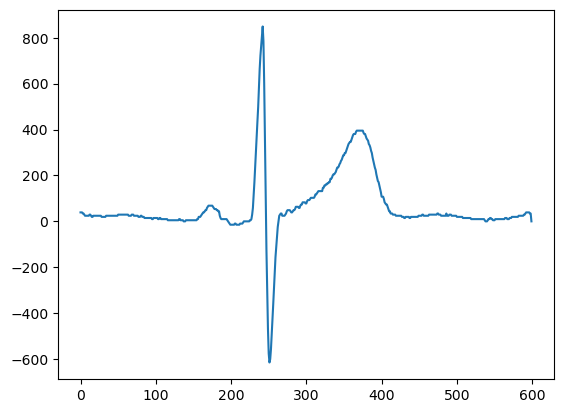

In [17]:
#Plot median waveform from dicom file
plt.plot(dicom["MedianWaveforms"]["V5"])

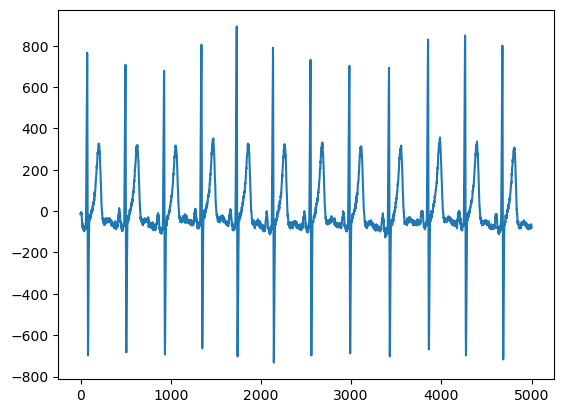

In [18]:
#Plot waveform from dicom file
plt.plot(dicom["Waveforms"]["V5"])